In [2]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm
import time
import csv

# Step 1: Get S&P 500 companies table
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {"User-Agent": "Mozilla/5.0 (compatible; sp500-fetcher/1.0; +https://example.com)"}
resp = requests.get(url, headers=headers, timeout=20)
resp.raise_for_status()

soup = BeautifulSoup(resp.text, "html.parser")
table = soup.find("table", {"class": "wikitable"})

df = pd.read_html(str(table))[0]

# Step 2: Get company Wikipedia URLs
base = "https://en.wikipedia.org"
links = [base + a["href"] for a in table.select("tbody tr td:nth-of-type(2) a[href]")]
df = df.iloc[:len(links)].copy()
df["Wikipedia_URL"] = links

# Step 3: Fetch short intro for each company
def get_intro(url):
    title = url.split("/wiki/")[-1]
    api_url = f"https://en.wikipedia.org/api/rest_v1/page/summary/{title}"
    try:
        r = requests.get(api_url, headers=headers, timeout=10)
        r.raise_for_status()
        return r.json().get("extract", "")
    except Exception:
        return ""

intros = []
for link in tqdm(df["Wikipedia_URL"], desc="Fetching intros"):
    intros.append(get_intro(link))
    time.sleep(0.3)  # delay to avoid being blocked

df["Intro"] = intros

# Step 4: Clean and deduplicate data
df = df[["Symbol", "Security", "Wikipedia_URL", "Intro"]].copy()
df["Symbol"] = df["Symbol"].astype(str).str.strip()
df["Security"] = df["Security"].astype(str).str.strip()
df = df[df["Symbol"] != ""]
df = df.dropna(subset=["Symbol"])

before = len(df)
df = df.drop_duplicates(subset=["Symbol"], keep="first").reset_index(drop=True)
after = len(df)

print(f"Rows before dedupe: {before}, after dedupe: {after} (unique symbols)")

# Step 5: Add ID and finalize column order
df.insert(0, "ID", range(1, len(df) + 1))

# Step 6: Save to CSV with proper quoting
out_path = "sp500_wiki_intros_clean.csv"
df.to_csv(out_path, index=False, encoding="utf-8", quoting=csv.QUOTE_ALL)

print(f"✅ Exported {len(df)} rows to {out_path}")
print(f"Unique symbols: {df['Symbol'].nunique()}")

C:\Users\jacks\AppData\Local\Temp\ipykernel_12572\3047603493.py:17: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
Fetching intros:   3%|▎         | 15/503 [00:05<03:06,  2.61it/s]


KeyboardInterrupt: 

In [3]:
import pandas as pd
import re

# Load the cleaned CSV
df = pd.read_csv("sp500_wiki_intros_clean.csv")

print(f"Loaded {len(df)} companies")

# Prep intro text for embeddings
def prep_text_for_embedding(text):
    """Clean and normalize text for vector embedding"""
    if pd.isna(text) or text == "":
        return ""
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove extra whitespace and newlines
    text = re.sub(r'\s+', ' ', text)
    
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s\.\,\-]', '', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text

# Apply preprocessing
df["Intro_Embedding_Ready"] = df["Intro"].apply(prep_text_for_embedding)

# Remove rows with empty intros
df_ready = df[df["Intro_Embedding_Ready"] != ""].copy()

print(f"✅ Prepared {len(df_ready)} intro texts for embedding")
print(f"Dropped {len(df) - len(df_ready)} rows with empty intros")

# Display sample
print("\nSample preprocessed text:")
print(df_ready[["Symbol", "Security", "Intro_Embedding_Ready"]].head(3))

Loaded 503 companies
✅ Prepared 502 intro texts for embedding
Dropped 1 rows with empty intros

Sample preprocessed text:
  Symbol             Security  \
0    MMM                   3M   
1    AOS          A. O. Smith   
2    ABT  Abbott Laboratories   

                               Intro_Embedding_Ready  
0  the 3m company is an american multinational co...  
1  a. o. smith corporation is an american manufac...  
2  abbott laboratories is an american multination...  


In [4]:
from openai import OpenAI
import numpy as np
from tqdm import tqdm
import time
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Initialize OpenAI client with API key from .env
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Configuration
EMBEDDING_MODEL = "text-embedding-3-small"  # or "text-embedding-3-large" for higher quality
BATCH_SIZE = 100  # OpenAI allows up to 2048 texts per request, but smaller batches are safer

def get_embeddings_batch(texts, model=EMBEDDING_MODEL):
    """Get embeddings for a batch of texts"""
    try:
        response = client.embeddings.create(
            input=texts,
            model=model
        )
        return [item.embedding for item in response.data]
    except Exception as e:
        print(f"Error getting embeddings: {e}")
        return None

# Prepare data for embedding
texts_to_embed = df_ready["Intro_Embedding_Ready"].tolist()
total_texts = len(texts_to_embed)

print(f"Creating embeddings for {total_texts} companies using {EMBEDDING_MODEL}...")

# Process in batches
all_embeddings = []
for i in tqdm(range(0, total_texts, BATCH_SIZE)):
    batch = texts_to_embed[i:i + BATCH_SIZE]
    embeddings = get_embeddings_batch(batch)
    
    if embeddings:
        all_embeddings.extend(embeddings)
    else:
        # If batch fails, try one at a time
        for text in batch:
            emb = get_embeddings_batch([text])
            all_embeddings.extend(emb if emb else [[0] * 1536])  # fallback to zero vector
    
    time.sleep(0.2)  # Rate limiting

# Add embeddings to dataframe
df_ready["Embedding"] = all_embeddings

# Create a lookup dictionary for easy access
embedding_lookup = dict(zip(df_ready["Symbol"], df_ready["Embedding"]))

print(f"✅ Created {len(all_embeddings)} embeddings")
print(f"Embedding dimensions: {len(all_embeddings[0])}")
print(f"\nSample companies with embeddings:")
print(df_ready[["ID", "Symbol", "Security"]].head())

# Optional: Save embeddings to numpy file for later use
np.save("sp500_embeddings.npy", np.array(all_embeddings))
df_ready[["ID", "Symbol", "Security", "Wikipedia_URL"]].to_csv("sp500_embedding_metadata.csv", index=False)

print("\n✅ Saved embeddings to sp500_embeddings.npy")
print("✅ Saved metadata to sp500_embedding_metadata.csv")

Creating embeddings for 502 companies using text-embedding-3-small...


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]

✅ Created 502 embeddings
Embedding dimensions: 1536

Sample companies with embeddings:
   ID Symbol             Security
0   1    MMM                   3M
1   2    AOS          A. O. Smith
2   3    ABT  Abbott Laboratories
3   4   ABBV               AbbVie
4   5    ACN            Accenture

✅ Saved embeddings to sp500_embeddings.npy
✅ Saved metadata to sp500_embedding_metadata.csv


Original embedding shape: (502, 1536)
Reduced embedding shape: (502, 50)
Explained variance: 56.33%

Performing HDBSCAN clustering...

✅ Clustering complete!
Number of clusters found: 11
Number of noise points (cluster -1): 359
Clustered companies: 143

Cluster sizes:
  Noise (cluster -1): 359 companies
  Cluster 0: 5 companies
  Cluster 1: 5 companies
  Cluster 2: 8 companies
  Cluster 3: 38 companies
  Cluster 4: 6 companies
  Cluster 5: 6 companies
  Cluster 6: 9 companies
  Cluster 7: 27 companies
  Cluster 8: 18 companies
  Cluster 9: 8 companies
  Cluster 10: 13 companies

Sample companies from each cluster:

Cluster 0:
  • MMM: 3M
  • MLM: Martin Marietta Materials
  • MHK: Mohawk Industries
  • MOS: Mosaic Company (The)
  • MSCI: MSCI Inc.

Cluster 1:
  • DRI: Darden Restaurants
  • DPZ: Domino's
  • GEN: Gen Digital
  • GDDY: GoDaddy
  • ROST: Ross Stores

Cluster 2:
  • BALL: Ball Corporation
  • CPB: Campbell's Company (The)
  • HAS: Hasbro
  • HSY: Hershey Company (The)
  •

c:\Users\jacks\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jacks\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


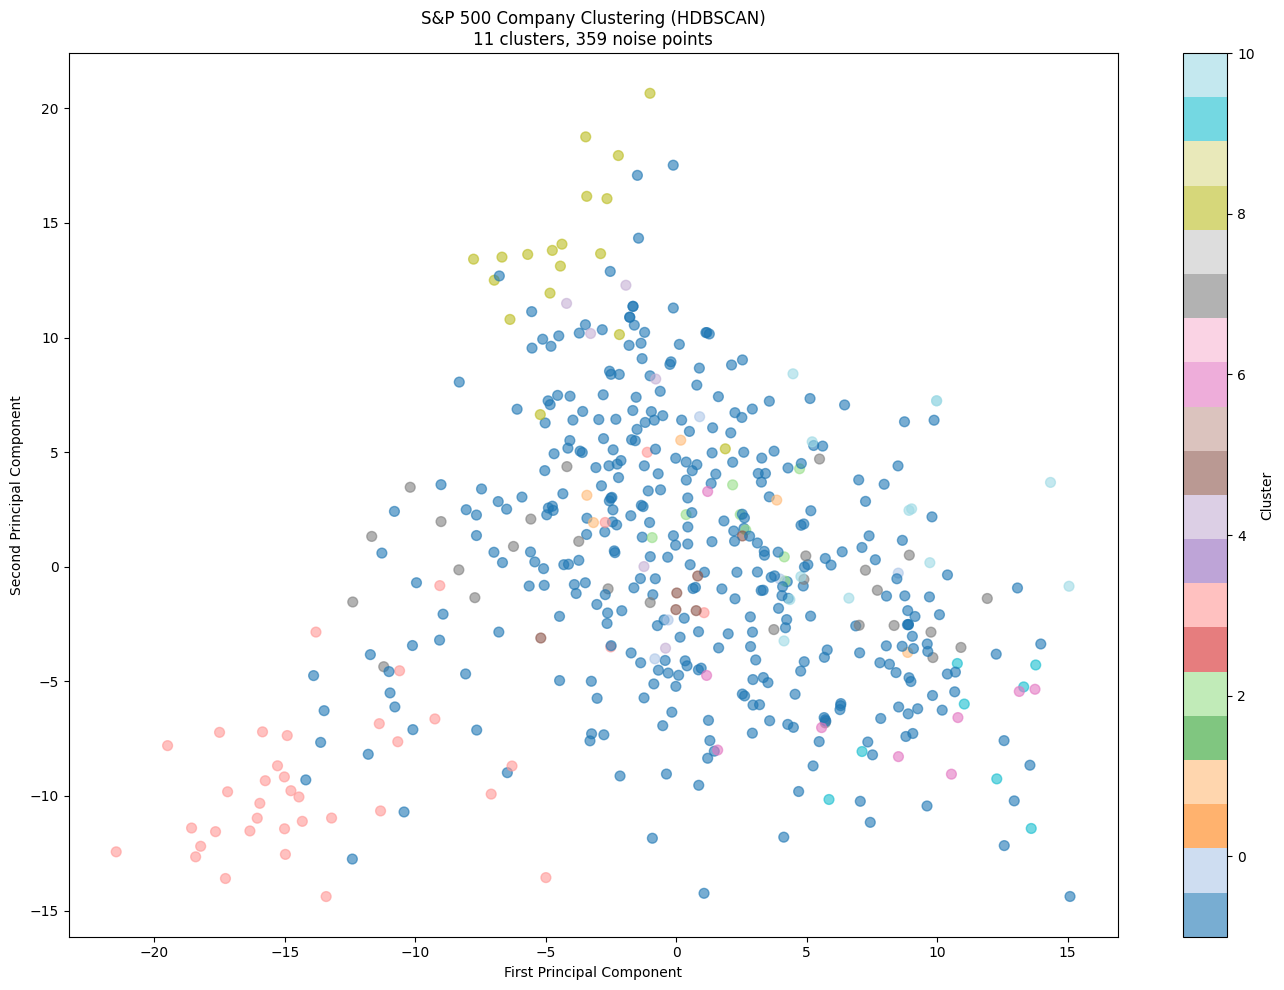


✅ Saved clustered data to sp500_clustered.csv


In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns

# Load embeddings if not already in memory
if 'all_embeddings' not in locals() or not isinstance(all_embeddings, np.ndarray):
    all_embeddings = np.load("sp500_embeddings.npy")
    df_ready = pd.read_csv("sp500_embedding_metadata.csv")

# Convert to numpy array if it's a list
if isinstance(all_embeddings, list):
    all_embeddings = np.array(all_embeddings)

print(f"Original embedding shape: {all_embeddings.shape}")

# Step 1: Normalize embeddings (optional but often helps with clustering)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(all_embeddings)

# Step 2: Optional dimensionality reduction with PCA
# This can help HDBSCAN perform better and run faster
n_components = 50  # Reduce from 1536 to 50 dimensions
pca = PCA(n_components=n_components, random_state=42)
embeddings_reduced = pca.fit_transform(embeddings_scaled)

print(f"Reduced embedding shape: {embeddings_reduced.shape}")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# Step 3: Perform HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,        # Minimum points to form a cluster
    min_samples=3,              # Conservative core point threshold
    metric='euclidean',
    cluster_selection_epsilon=0.0,
    cluster_selection_method='eom'
)

print("\nPerforming HDBSCAN clustering...")
cluster_labels = clusterer.fit_predict(embeddings_reduced)

# Add cluster labels to dataframe
df_ready["Cluster"] = cluster_labels

# Analyze clustering results
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"\n✅ Clustering complete!")
print(f"Number of clusters found: {n_clusters}")
print(f"Number of noise points (cluster -1): {n_noise}")
print(f"Clustered companies: {len(df_ready) - n_noise}")

# Show cluster distribution
cluster_counts = df_ready['Cluster'].value_counts().sort_index()
print("\nCluster sizes:")
for cluster_id, count in cluster_counts.items():
    if cluster_id == -1:
        print(f"  Noise (cluster -1): {count} companies")
    else:
        print(f"  Cluster {cluster_id}: {count} companies")

# Display sample companies from each cluster
print("\n" + "="*80)
print("Sample companies from each cluster:")
print("="*80)
for cluster_id in sorted(df_ready['Cluster'].unique()):
    if cluster_id == -1:
        continue
    print(f"\nCluster {cluster_id}:")
    sample = df_ready[df_ready['Cluster'] == cluster_id][['Symbol', 'Security']].head(10)
    for idx, row in sample.iterrows():
        print(f"  • {row['Symbol']}: {row['Security']}")

# Visualize clustering with 2D projection
pca_2d = PCA(n_components=2, random_state=42)
embeddings_2d = pca_2d.fit_transform(embeddings_scaled)

plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1], 
    c=cluster_labels, 
    cmap='tab20', 
    alpha=0.6,
    s=50
)
plt.colorbar(scatter, label='Cluster')
plt.title(f'S&P 500 Company Clustering (HDBSCAN)\n{n_clusters} clusters, {n_noise} noise points')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.tight_layout()
plt.show()

# Save clustering results
df_ready.to_csv("sp500_clustered.csv", index=False)
print(f"\n✅ Saved clustered data to sp500_clustered.csv")

In [7]:
import plotly.express as px
import plotly.graph_objects as go

# Use the 2D PCA projection from before (or recreate if needed)
if 'embeddings_2d' not in locals():
    pca_2d = PCA(n_components=2, random_state=42)
    embeddings_2d = pca_2d.fit_transform(embeddings_scaled)

# Add 2D coordinates to dataframe
df_ready['PC1'] = embeddings_2d[:, 0]
df_ready['PC2'] = embeddings_2d[:, 1]

# Create hover text with company info
df_ready['hover_text'] = (
    df_ready['Security'] + ' (' + df_ready['Symbol'] + ')' +
    '<br>Cluster: ' + df_ready['Cluster'].astype(str)
)

# Convert cluster to string for better color mapping
df_ready['Cluster_Label'] = df_ready['Cluster'].apply(
    lambda x: 'Noise' if x == -1 else f'Cluster {x}'
)

# Create interactive scatter plot
fig = px.scatter(
    df_ready,
    x='PC1',
    y='PC2',
    color='Cluster_Label',
    hover_name='Security',
    hover_data={
        'Symbol': True,
        'Cluster': True,
        'PC1': False,
        'PC2': False,
        'Cluster_Label': False
    },
    title=f'Interactive S&P 500 Company Clustering<br><sub>{n_clusters} clusters found, {n_noise} noise points</sub>',
    labels={'PC1': 'First Principal Component', 'PC2': 'Second Principal Component'},
    color_discrete_sequence=px.colors.qualitative.Light24,
    width=1200,
    height=800
)

# Customize markers
fig.update_traces(
    marker=dict(size=8, line=dict(width=0.5, color='white')),
    opacity=0.7
)

# Update layout
fig.update_layout(
    hovermode='closest',
    plot_bgcolor='white',
    legend_title_text='Clusters',
    font=dict(size=12),
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)

# Show the plot
fig.show()

# Optional: Save as HTML for sharing
fig.write_html("sp500_clustering_interactive.html")
print("✅ Saved interactive plot to sp500_clustering_interactive.html")

✅ Saved interactive plot to sp500_clustering_interactive.html


c:\Users\jacks\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Original data: (502, 1536)

--- Dimensionality Reduction ---
PCA to 100 dims - Explained variance: 74.98%


c:\Users\jacks\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP to 10 dims - Complete

--- HDBSCAN Clustering ---
Number of clusters: 22
Noise points: 62 (12.4%)
Clustered companies: 440

Cluster stability scores:
  Cluster 0: 0.151
  Cluster 1: 0.213
  Cluster 2: 0.420
  Cluster 3: 0.183
  Cluster 4: 0.176
  Cluster 5: 0.186
  Cluster 6: 0.194
  Cluster 7: 0.039
  Cluster 8: 0.263
  Cluster 9: 0.170
  Cluster 10: 0.083
  Cluster 11: 0.055
  Cluster 12: 0.309
  Cluster 13: 0.133
  Cluster 14: 0.363
  Cluster 15: 0.158
  Cluster 16: 0.011
  Cluster 17: 0.125
  Cluster 18: 0.053
  Cluster 19: 0.177
  Cluster 20: 0.080
  Cluster 21: 0.085

Cluster Analysis:

Noise (cluster -1): 62 companies

Cluster 0: 37 companies
  • AZO: AutoZone
  • BBY: Best Buy
  • BLDR: Builders FirstSource
  • KMX: CarMax
  • CPRT: Copart
  • COST: Costco
  • DRI: Darden Restaurants
  • DECK: Deckers Brands
  • DAL: Delta Air Lines
  • DG: Dollar General
  • DLTR: Dollar Tree
  • DPZ: Domino's
  • DASH: DoorDash
  • DHI: D. R. Horton
  • EL: Estée Lauder Companies (The)



c:\Users\jacks\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\jacks\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\jacks\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



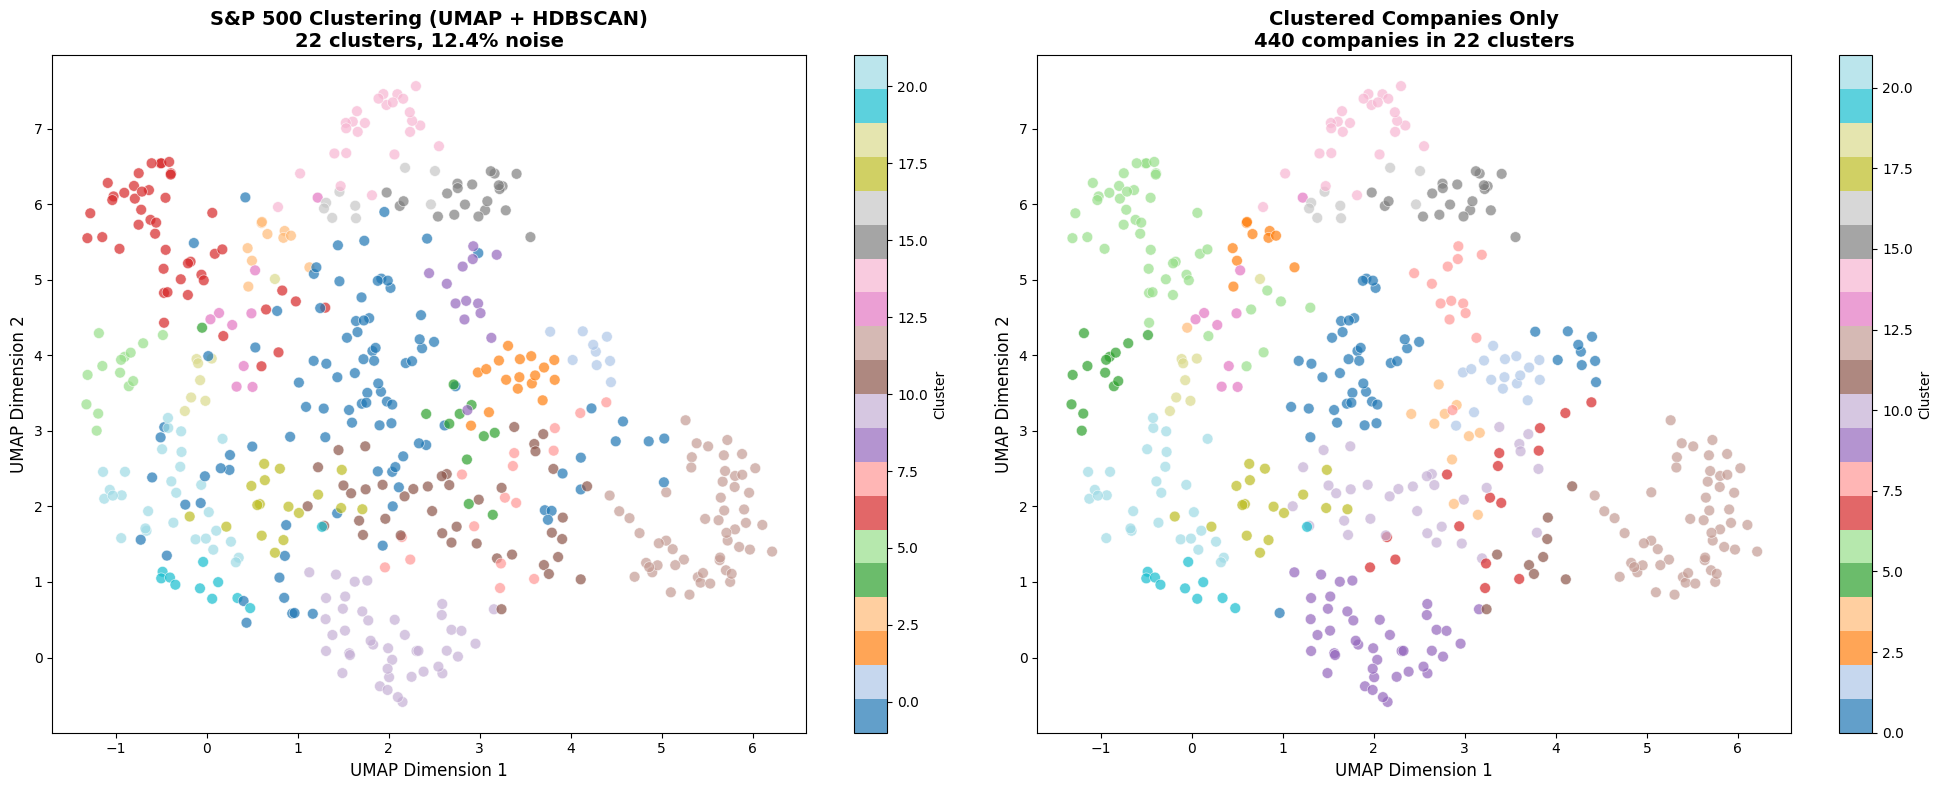


✅ Saved improved clustering to sp500_clustered_improved.csv

TUNING SUGGESTIONS:
Current noise level: 12.4%

If you want FEWER noise points (more companies clustered):
  • Decrease min_cluster_size (try 5-7)
  • Decrease min_samples (try 1-2)
  • Increase cluster_selection_epsilon (try 0.8-1.0)

If you want TIGHTER, MORE DISTINCT clusters:
  • Increase min_cluster_size (try 10-15)
  • Increase min_samples (try 3-5)
  • Decrease cluster_selection_epsilon (try 0.0-0.3)

If clusters look too merged:
  • Try different n_neighbors in UMAP (try 5-30)
  • Adjust min_dist in UMAP (try 0.0-0.5)


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
all_embeddings = np.array(np.load("sp500_embeddings.npy"))
df_ready = pd.read_csv("sp500_embedding_metadata.csv")

print(f"Original data: {all_embeddings.shape}")

# ============================================================================
# STEP 1: Enhanced Dimensionality Reduction
# ============================================================================
# Try UMAP instead of just PCA - it preserves local structure better for clustering

print("\n--- Dimensionality Reduction ---")

# First use PCA to reduce to manageable size (removes noise)
pca_initial = PCA(n_components=100, random_state=42)
embeddings_pca = pca_initial.fit_transform(all_embeddings)
print(f"PCA to 100 dims - Explained variance: {pca_initial.explained_variance_ratio_.sum():.2%}")

# Then use UMAP for better cluster separation
umap_reducer = umap.UMAP(
    n_neighbors=15,        # Balance between local and global structure
    min_dist=0.1,          # Minimum distance between points
    n_components=10,       # Reduce to 10 dimensions for clustering
    metric='cosine',       # Cosine distance works well for embeddings
    random_state=42
)
embeddings_umap = umap_reducer.fit_transform(embeddings_pca)
print(f"UMAP to 10 dims - Complete")

# ============================================================================
# STEP 2: Normalize for clustering
# ============================================================================
scaler = StandardScaler()
embeddings_normalized = scaler.fit_transform(embeddings_umap)

# ============================================================================
# STEP 3: Optimized HDBSCAN Parameters
# ============================================================================
print("\n--- HDBSCAN Clustering ---")

# More aggressive parameters to reduce noise
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=8,              # Smaller = more clusters, less noise
    min_samples=2,                   # Lower = more lenient clustering
    metric='euclidean',
    cluster_selection_epsilon=0.5,   # Allow merging of close clusters
    cluster_selection_method='eom',  # Excess of Mass method
    alpha=1.0                        # Default linkage strength
)

cluster_labels = clusterer.fit_predict(embeddings_normalized)
df_ready["Cluster"] = cluster_labels

# Calculate clustering quality metrics
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)
noise_pct = (n_noise / len(cluster_labels)) * 100

print(f"Number of clusters: {n_clusters}")
print(f"Noise points: {n_noise} ({noise_pct:.1f}%)")
print(f"Clustered companies: {len(df_ready) - n_noise}")

# Cluster persistence scores (higher = more stable clusters)
if hasattr(clusterer, 'cluster_persistence_'):
    print("\nCluster stability scores:")
    for i, score in enumerate(clusterer.cluster_persistence_):
        print(f"  Cluster {i}: {score:.3f}")

# ============================================================================
# STEP 4: Analyze Cluster Quality
# ============================================================================
print("\n" + "="*80)
print("Cluster Analysis:")
print("="*80)

cluster_counts = df_ready['Cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    if cluster_id == -1:
        print(f"\nNoise (cluster -1): {count} companies")
    else:
        print(f"\n{'='*60}")
        print(f"Cluster {cluster_id}: {count} companies")
        print(f"{'='*60}")
        sample = df_ready[df_ready['Cluster'] == cluster_id][['Symbol', 'Security']].head(15)
        for idx, row in sample.iterrows():
            print(f"  • {row['Symbol']}: {row['Security']}")

# ============================================================================
# STEP 5: Create 2D Visualization with UMAP
# ============================================================================
print("\n--- Creating 2D Visualization ---")

# Use UMAP for 2D visualization (better than PCA for clusters)
umap_2d = umap.UMAP(
    n_neighbors=15,
    min_dist=0.3,
    n_components=2,
    metric='cosine',
    random_state=42
)
embeddings_2d = umap_2d.fit_transform(embeddings_pca)

df_ready['X'] = embeddings_2d[:, 0]
df_ready['Y'] = embeddings_2d[:, 1]

# Enhanced matplotlib visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: All clusters
scatter1 = ax1.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=cluster_labels,
    cmap='tab20',
    alpha=0.7,
    s=60,
    edgecolors='white',
    linewidth=0.5
)
ax1.set_title(f'S&P 500 Clustering (UMAP + HDBSCAN)\n{n_clusters} clusters, {noise_pct:.1f}% noise', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('UMAP Dimension 1', fontsize=12)
ax1.set_ylabel('UMAP Dimension 2', fontsize=12)
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# Plot 2: Without noise points
non_noise = cluster_labels != -1
scatter2 = ax2.scatter(
    embeddings_2d[non_noise, 0],
    embeddings_2d[non_noise, 1],
    c=cluster_labels[non_noise],
    cmap='tab20',
    alpha=0.7,
    s=60,
    edgecolors='white',
    linewidth=0.5
)
ax2.set_title(f'Clustered Companies Only\n{len(df_ready) - n_noise} companies in {n_clusters} clusters', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('UMAP Dimension 1', fontsize=12)
ax2.set_ylabel('UMAP Dimension 2', fontsize=12)
plt.colorbar(scatter2, ax=ax2, label='Cluster')

plt.tight_layout()
plt.show()

# Save results
df_ready.to_csv("sp500_clustered_improved.csv", index=False)
print(f"\n✅ Saved improved clustering to sp500_clustered_improved.csv")

# ============================================================================
# STEP 6: Parameter Tuning Suggestions
# ============================================================================
print("\n" + "="*80)
print("TUNING SUGGESTIONS:")
print("="*80)
print(f"Current noise level: {noise_pct:.1f}%")
print("\nIf you want FEWER noise points (more companies clustered):")
print("  • Decrease min_cluster_size (try 5-7)")
print("  • Decrease min_samples (try 1-2)")
print("  • Increase cluster_selection_epsilon (try 0.8-1.0)")
print("\nIf you want TIGHTER, MORE DISTINCT clusters:")
print("  • Increase min_cluster_size (try 10-15)")
print("  • Increase min_samples (try 3-5)")
print("  • Decrease cluster_selection_epsilon (try 0.0-0.3)")
print("\nIf clusters look too merged:")
print("  • Try different n_neighbors in UMAP (try 5-30)")
print("  • Adjust min_dist in UMAP (try 0.0-0.5)")